In [ ]:
%pip install -r ../requirements.txt

# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('hotel_booking.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nBasic Information:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (119390, 36)

Columns: ['hotel', 'is_canceled', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status', 'reservation_status_date', 'name', 'email', 'phone-number', 'credit_card']

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119

Overall cancellation rate: 37.04%


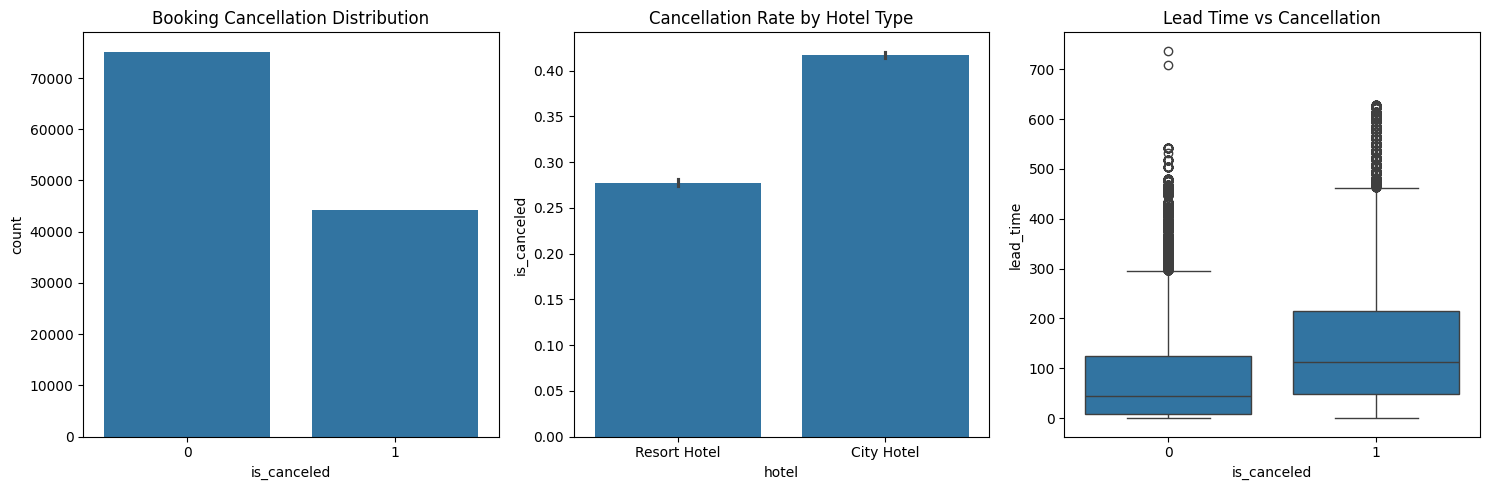


Cancellation rates by market segment:
market_segment
Undefined        1.000000
Groups           0.610620
Online TA        0.367211
Offline TA/TO    0.343160
Aviation         0.219409
Corporate        0.187347
Direct           0.153419
Complementary    0.130552
Name: is_canceled, dtype: float64

Average lead time for cancelled vs non-cancelled bookings:
is_canceled
0     79.984687
1    144.848815
Name: lead_time, dtype: float64


In [2]:
# Remove sensitive information
columns_to_drop = ['name', 'email', 'phone-number', 'credit_card']
df = df.drop(columns=columns_to_drop)

# Basic statistics about cancellations
cancellation_rate = df['is_canceled'].mean() * 100
print(f"Overall cancellation rate: {cancellation_rate:.2f}%")

# Create some initial visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Cancellation distribution
plt.subplot(131)
sns.countplot(data=df, x='is_canceled')
plt.title('Booking Cancellation Distribution')

# Plot 2: Cancellation rate by hotel type
plt.subplot(132)
sns.barplot(data=df, x='hotel', y='is_canceled')
plt.title('Cancellation Rate by Hotel Type')

# Plot 3: Lead time distribution by cancellation status
plt.subplot(133)
sns.boxplot(data=df, x='is_canceled', y='lead_time')
plt.title('Lead Time vs Cancellation')

plt.tight_layout()
plt.show()

# Additional insights
print("\nCancellation rates by market segment:")
print(df.groupby('market_segment')['is_canceled'].mean().sort_values(ascending=False))

print("\nAverage lead time for cancelled vs non-cancelled bookings:")
print(df.groupby('is_canceled')['lead_time'].mean())


Correlations with cancellation:
lead_time: 0.293
total_of_special_requests: -0.235
required_car_parking_spaces: -0.195
previous_cancellations: 0.110
previous_bookings_not_canceled: -0.057
adr: 0.048
total_guests: 0.047
total_nights: 0.018

Cancellation rate by deposit type:
deposit_type
Non Refund    0.993624
No Deposit    0.283770
Refundable    0.222222
Name: is_canceled, dtype: float64

Cancellation rate by customer type:
customer_type
Transient          0.407463
Contract           0.309617
Transient-Party    0.254299
Group              0.102253
Name: is_canceled, dtype: float64


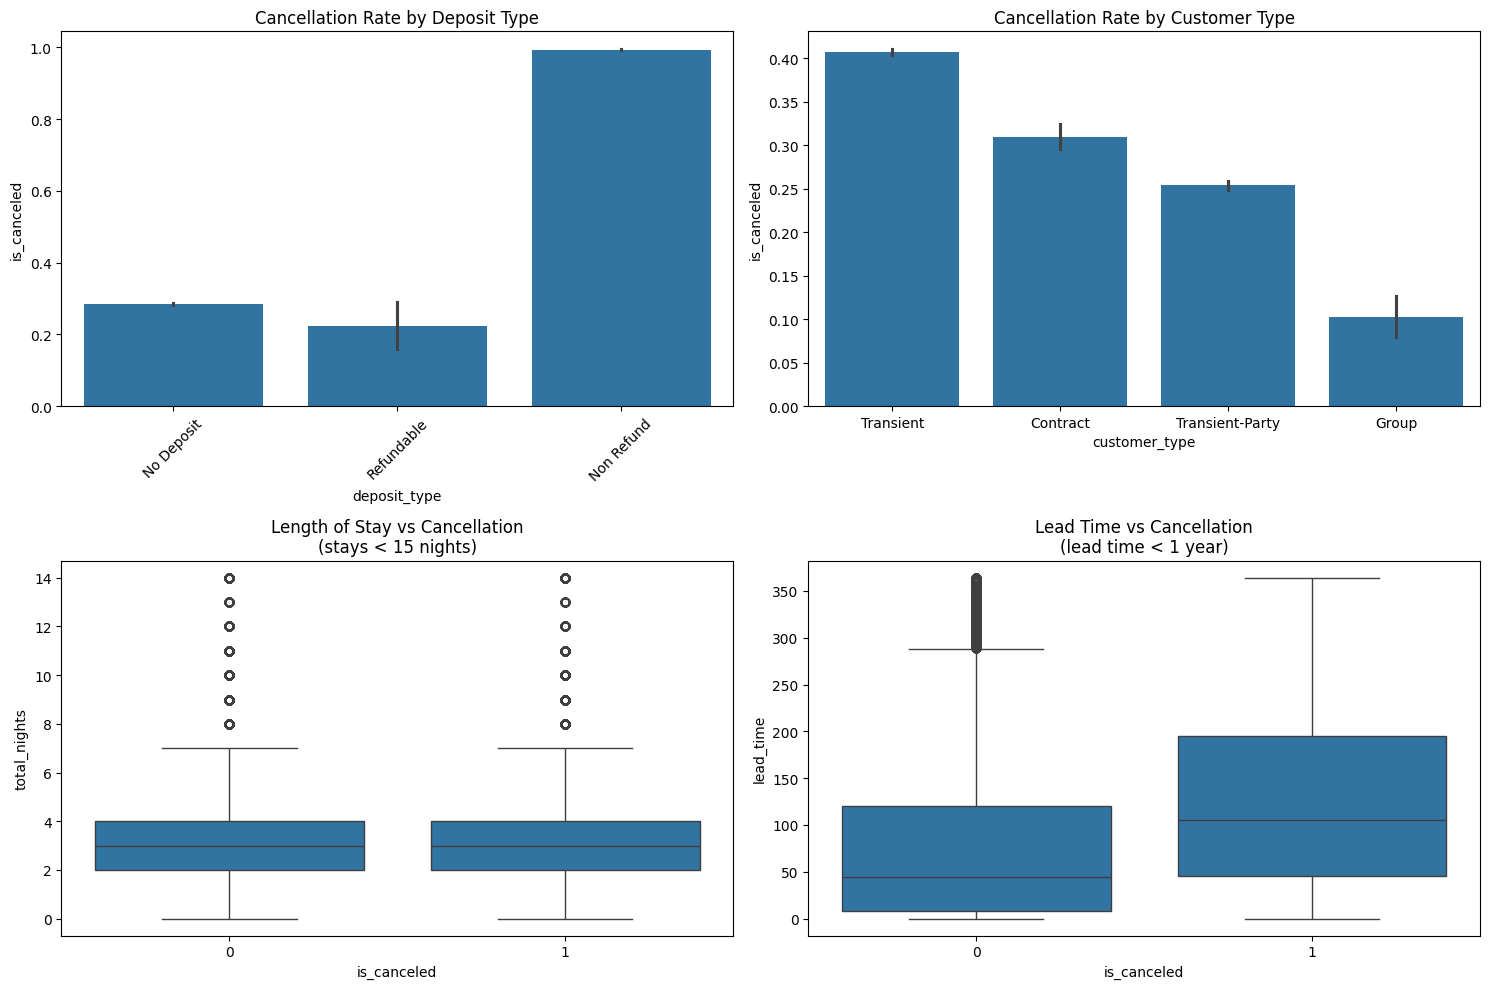

In [4]:
# Create more detailed features
df['total_nights'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
df['total_guests'] = df['adults'] + df['children'].fillna(0) + df['babies']

# Calculate correlations correctly
numerical_cols = ['lead_time', 'total_nights', 'total_guests', 'adr', 
                 'required_car_parking_spaces', 'total_of_special_requests',
                 'previous_cancellations', 'previous_bookings_not_canceled']

correlations = {col: df['is_canceled'].corr(df[col]) for col in numerical_cols}
print("\nCorrelations with cancellation:")
for col, corr in sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{col}: {corr:.3f}")

# Print deposit type and customer type statistics
print("\nCancellation rate by deposit type:")
print(df.groupby('deposit_type')['is_canceled'].mean().sort_values(ascending=False))

print("\nCancellation rate by customer type:")
print(df.groupby('customer_type')['is_canceled'].mean().sort_values(ascending=False))

# Visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Cancellation rate by deposit type
plt.subplot(221)
sns.barplot(data=df, x='deposit_type', y='is_canceled')
plt.title('Cancellation Rate by Deposit Type')
plt.xticks(rotation=45)

# Plot 2: Cancellation rate by customer type
plt.subplot(222)
sns.barplot(data=df, x='customer_type', y='is_canceled')
plt.title('Cancellation Rate by Customer Type')

# Plot 3: Total nights distribution for cancelled vs non-cancelled
plt.subplot(223)
sns.boxplot(data=df[df['total_nights'] < 15], x='is_canceled', y='total_nights')
plt.title('Length of Stay vs Cancellation\n(stays < 15 nights)')

# Plot 4: Lead time distribution by cancellation
plt.subplot(224)
sns.boxplot(data=df[df['lead_time'] < 365], x='is_canceled', y='lead_time')
plt.title('Lead Time vs Cancellation\n(lead time < 1 year)')

plt.tight_layout()
plt.show()

In [5]:
# Create feature engineering pipeline
def engineer_features(df):
    # Create copy to avoid modifying original
    df_proc = df.copy()
    
    # Temporal features
    df_proc['arrival_date'] = pd.to_datetime(df_proc['arrival_date_year'].astype(str) + '-' + 
                                           df_proc['arrival_date_month'] + '-' + 
                                           df_proc['arrival_date_day_of_month'].astype(str))
    df_proc['booking_date'] = df_proc['arrival_date'] - pd.to_timedelta(df_proc['lead_time'], unit='D')
    df_proc['is_weekend_arrival'] = df_proc['arrival_date'].dt.dayofweek >= 5
    
    # Aggregate features
    df_proc['total_nights'] = df_proc['stays_in_weekend_nights'] + df_proc['stays_in_week_nights']
    df_proc['total_guests'] = df_proc['adults'] + df_proc['children'].fillna(0) + df_proc['babies']
    
    # Room type match
    df_proc['got_desired_room'] = (df_proc['reserved_room_type'] == df_proc['assigned_room_type']).astype(int)
    
    # Drop unnecessary columns
    cols_to_drop = ['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month',
                    'arrival_date_week_number', 'arrival_date', 'reservation_status', 
                    'reservation_status_date']
    
    return df_proc.drop(columns=cols_to_drop)

# Handle missing values
def handle_missing_values(df):
    df_clean = df.copy()
    
    # Fill missing values
    df_clean['children'] = df_clean['children'].fillna(0)
    df_clean['country'] = df_clean['country'].fillna('Unknown')
    df_clean['agent'] = df_clean['agent'].fillna(0)
    df_clean['company'] = df_clean['company'].fillna(0)
    
    return df_clean

# Run preprocessing
print("Starting preprocessing...")
df_processed = engineer_features(df)
df_processed = handle_missing_values(df_processed)

# Show resulting features
print("\nProcessed features:")
print(df_processed.columns.tolist())

# Show sample of engineered features
print("\nSample of engineered features:")
print(df_processed[['booking_date', 'is_weekend_arrival', 'total_nights', 
                   'total_guests', 'got_desired_room']].head())

Starting preprocessing...

Processed features:
['hotel', 'is_canceled', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights', 'total_guests', 'booking_date', 'is_weekend_arrival', 'got_desired_room']

Sample of engineered features:
  booking_date  is_weekend_arrival  total_nights  total_guests  \
0   2014-07-24               False             0           2.0   
1   2013-06-24               False             0           2.0   
2   2015-06-24               False             1           1.0   
3   2015-06-18               False             1           1.0   
4   2015-06-17               Fa

Training model...

Making predictions...


/home/nando/Local/mindd/.conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/nando/Local/mindd/.conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(



Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.91     14907
           1       0.89      0.81      0.85      8971

    accuracy                           0.89     23878
   macro avg       0.89      0.87      0.88     23878
weighted avg       0.89      0.89      0.89     23878


ROC-AUC Score: 0.957


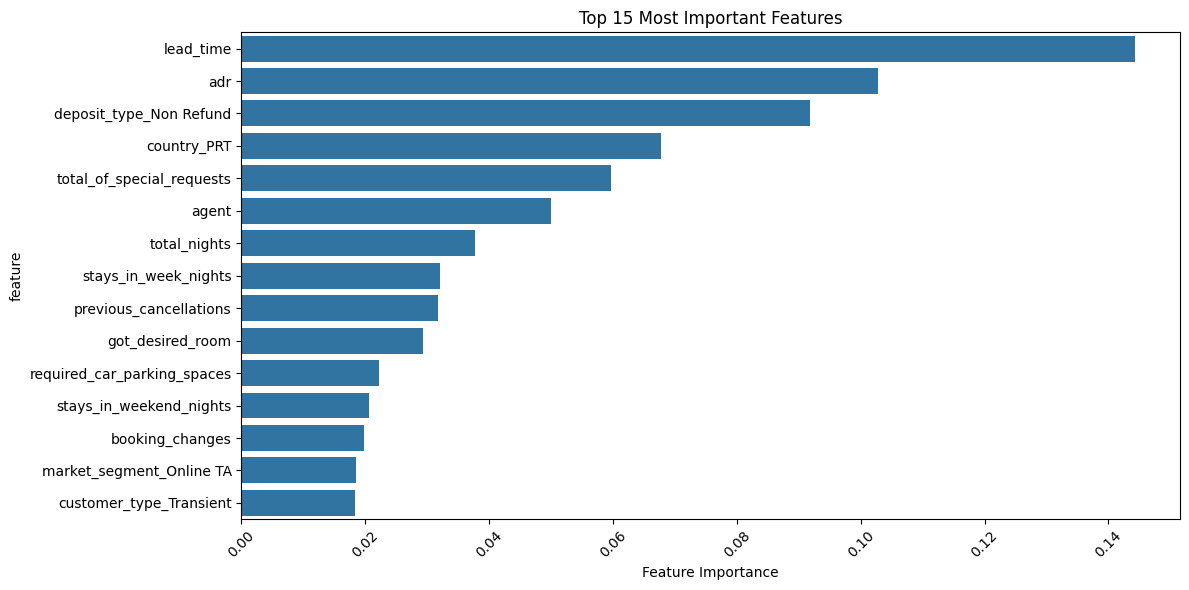


Top 10 Most Important Features:
                       feature  importance
0                    lead_time    0.144347
13                         adr    0.102837
229    deposit_type_Non Refund    0.091821
156                country_PRT    0.067812
15   total_of_special_requests    0.059708
10                       agent    0.049932
16                total_nights    0.037644
2         stays_in_week_nights    0.032039
7       previous_cancellations    0.031730
19            got_desired_room    0.029317


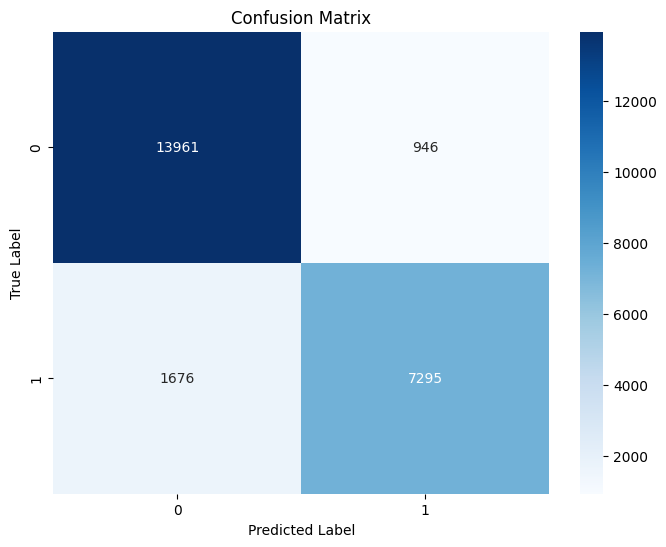


Model Performance Summary:
Total samples in test set: 23878
Correct predictions: 21256
Accuracy: 0.890

Detailed Metrics:
True Negatives (Correctly predicted non-cancellations): 13961
False Positives (Incorrectly predicted cancellations): 946
False Negatives (Missed cancellations): 1676
True Positives (Correctly predicted cancellations): 7295
Precision (Of predicted cancellations, what fraction were actual cancellations): 0.885
Recall (Of actual cancellations, what fraction were caught): 0.813


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Separate features and target
X = df_processed.drop('is_canceled', axis=1)
y = df_processed['is_canceled']

# Split categorical and numerical columns
categorical_features = ['hotel', 'meal', 'country', 'market_segment', 
                       'distribution_channel', 'reserved_room_type',
                       'assigned_room_type', 'deposit_type', 'customer_type']
numerical_features = ['lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
                     'adults', 'children', 'babies', 'is_repeated_guest',
                     'previous_cancellations', 'previous_bookings_not_canceled',
                     'booking_changes', 'agent', 'company', 'days_in_waiting_list',
                     'adr', 'required_car_parking_spaces', 'total_of_special_requests',
                     'total_nights', 'total_guests', 'is_weekend_arrival', 'got_desired_room']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features)
    ])

# Create and train the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the model
print("Training model...")
model.fit(X_train, y_train)

# Make predictions
print("\nMaking predictions...")
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Print model performance
print("\nModel Performance:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.3f}")

# Get feature names after one-hot encoding
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(categorical_feature_names)

# Calculate feature importance
feature_importance = model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
importance_df = importance_df.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print some additional insights
print("\nModel Performance Summary:")
print(f"Total samples in test set: {len(y_test)}")
print(f"Correct predictions: {(y_pred == y_test).sum()}")
print(f"Accuracy: {(y_pred == y_test).mean():.3f}")

# Calculate class-wise metrics
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Metrics:")
print(f"True Negatives (Correctly predicted non-cancellations): {tn}")
print(f"False Positives (Incorrectly predicted cancellations): {fp}")
print(f"False Negatives (Missed cancellations): {fn}")
print(f"True Positives (Correctly predicted cancellations): {tp}")
print(f"Precision (Of predicted cancellations, what fraction were actual cancellations): {tp/(tp+fp):.3f}")
print(f"Recall (Of actual cancellations, what fraction were caught): {tp/(tp+fn):.3f}")